# 0. Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

from tqdm import tqdm
from scipy.stats import expon, lognorm, loguniform, randint, uniform
import plotly.graph_objects as go
import joblib
import shap

# 1. Data

In [2]:
df = pd.read_csv(
    "../data/processed/seoul_fine_dust_weather_2008_2021_for_ml.csv", 
    index_col=0, 
    parse_dates=True
).reset_index()

In [3]:
df.head()

,date,temp(°C),precipitation(mm),wind_speed(m/s),wind_direction,humidity(%),local_P(hPa),cloud_cover,lowest_ceiling(100m),month,PM10_Counts,PM25_Counts,log_PM10_Counts,log_PM25_Counts
0,2008-01-01 10:00:00,-7.6,0.0,4.6,340.0,47.0,1010.7,2.0,12.0,1,30.0,11.0,3.433987,2.484907
1,2008-01-01 11:00:00,-6.9,0.0,4.1,290.0,42.0,1010.7,2.0,12.0,1,29.0,13.0,3.401197,2.639057
2,2008-01-01 12:00:00,-5.8,0.0,4.1,290.0,42.0,1010.7,2.0,12.0,1,29.0,12.0,3.401197,2.564949
3,2008-01-01 13:00:00,-5.0,0.0,4.1,290.0,36.0,1009.9,0.0,10.0,1,28.0,12.0,3.367296,2.564949
4,2008-01-01 14:00:00,-4.4,0.0,4.1,290.0,36.0,1009.9,0.0,10.0,1,27.0,13.0,3.332205,2.639057


In [4]:
df["month"] = df["month"].astype("category")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122733 entries, 0 to 122732
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   date                  122733 non-null  datetime64[ns]
 1   temp(°C)              122733 non-null  float64       
 2   precipitation(mm)     122733 non-null  float64       
 3   wind_speed(m/s)       122733 non-null  float64       
 4   wind_direction        122733 non-null  float64       
 5   humidity(%)           122733 non-null  float64       
 6   local_P(hPa)          122733 non-null  float64       
 7   cloud_cover           122733 non-null  float64       
 8   lowest_ceiling(100m)  122733 non-null  float64       
 9   month                 122733 non-null  category      
 10  PM10_Counts           122733 non-null  float64       
 11  PM25_Counts           122733 non-null  float64       
 12  log_PM10_Counts       122733 non-null  float64       
 13 

# 2. Train/Test Split

In [6]:
train_df = df.query("date < '2016-01-01 00:00:00'")
test_df = df.query("date >= '2016-01-01 00:00:00'")

train_df.set_index("date", inplace=True)
test_df.set_index("date", inplace=True)

In [7]:
X_train = train_df.drop(
    columns=["PM10_Counts", "PM25_Counts", "log_PM10_Counts", "log_PM25_Counts"]
)
y_train = train_df["log_PM10_Counts"]

X_test = test_df.drop(
    columns=["PM10_Counts", "PM25_Counts", "log_PM10_Counts", "log_PM25_Counts"]
)
y_test = test_df["log_PM10_Counts"]

# 3. Model Load

In [8]:
model = joblib.load("../models/lgbm_model.pkl")

# 4. Feature Importance by LGBM

In [9]:
columns = (
    model.named_steps['columntransformer']
    .named_transformers_['standardscaler']
    .get_feature_names_out().tolist() +
    model.named_steps['columntransformer']
    .named_transformers_['onehotencoder']
    .get_feature_names_out().tolist()
)

In [10]:
X_test_enc = pd.DataFrame(
    model.named_steps["columntransformer"].transform(X_test),
    columns=columns,
    index=X_test.index
)

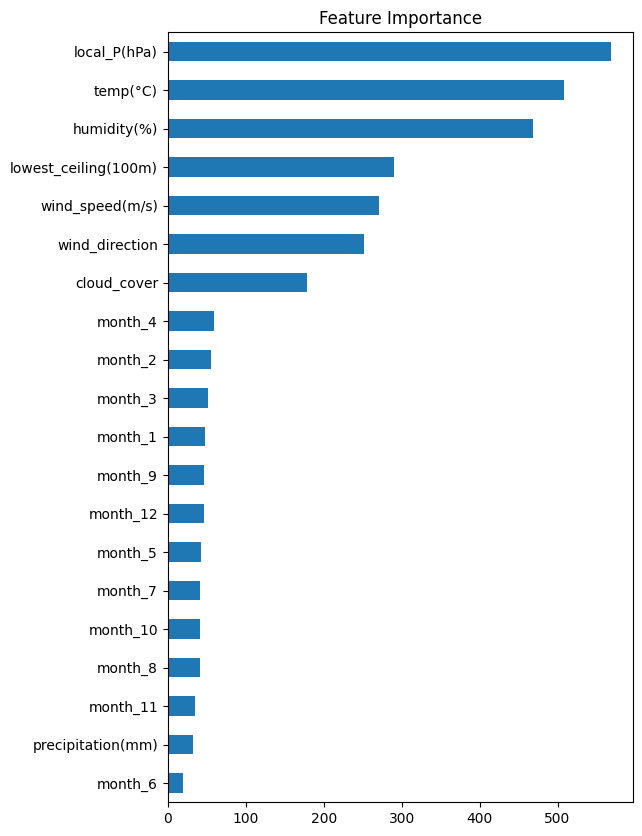

In [11]:
lgbm_feat_importance = pd.Series(
    (model.named_steps["lgbmregressor"].feature_importances_), columns
).sort_values(ascending=False)

lgbm_feat_importance.plot.barh(figsize=(6, 10), title="Feature Importance").invert_yaxis()
plt.show();

When the inherent feature importance feature of `LightGBM` was used, the rank of the important features were a bit different from that of intuition.

# Feature Importance by SHAP

In [12]:
shap.initjs()

In [13]:
lgbm_explainer = shap.Explainer(model.named_steps["lgbmregressor"])

In [14]:
shap_values = lgbm_explainer(X_test_enc)

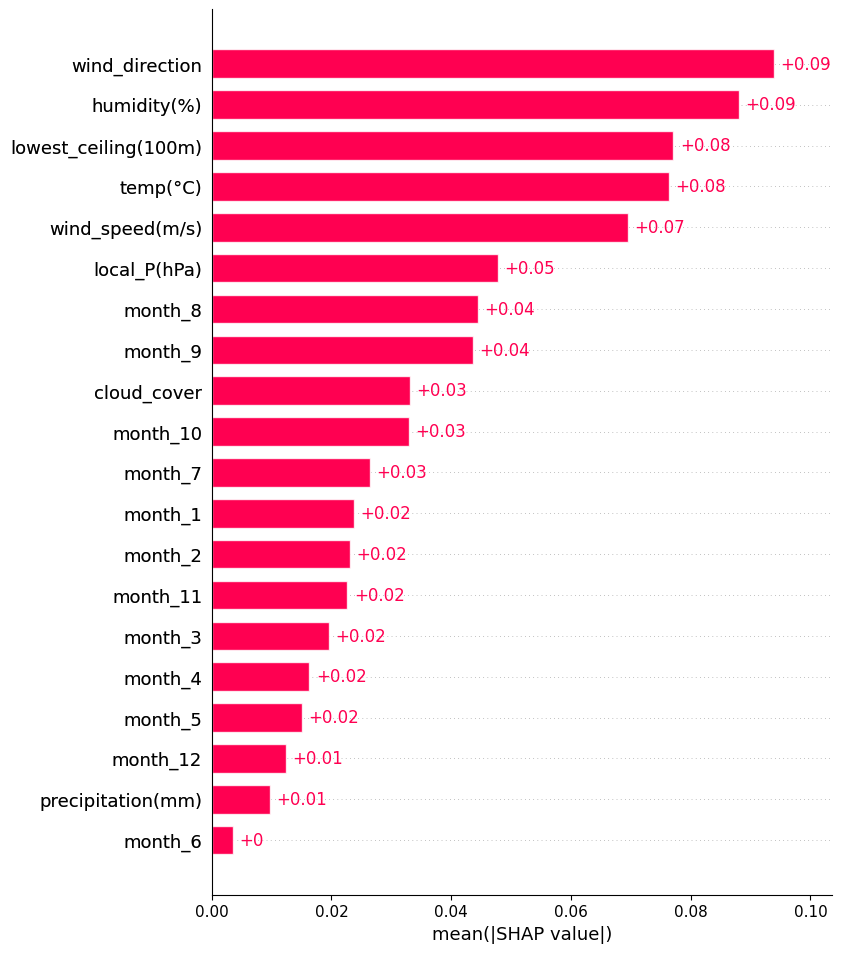

In [15]:
fig = plt.gcf()
shap.plots.bar(shap_values, max_display=20)
fig.savefig('../img/feature_rank.png', bbox_inches='tight')

When the rank of features found by using `shap` was close to that of intuition and the results of EDA. `wind_direction` was the most important parameter in determining the particle count.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


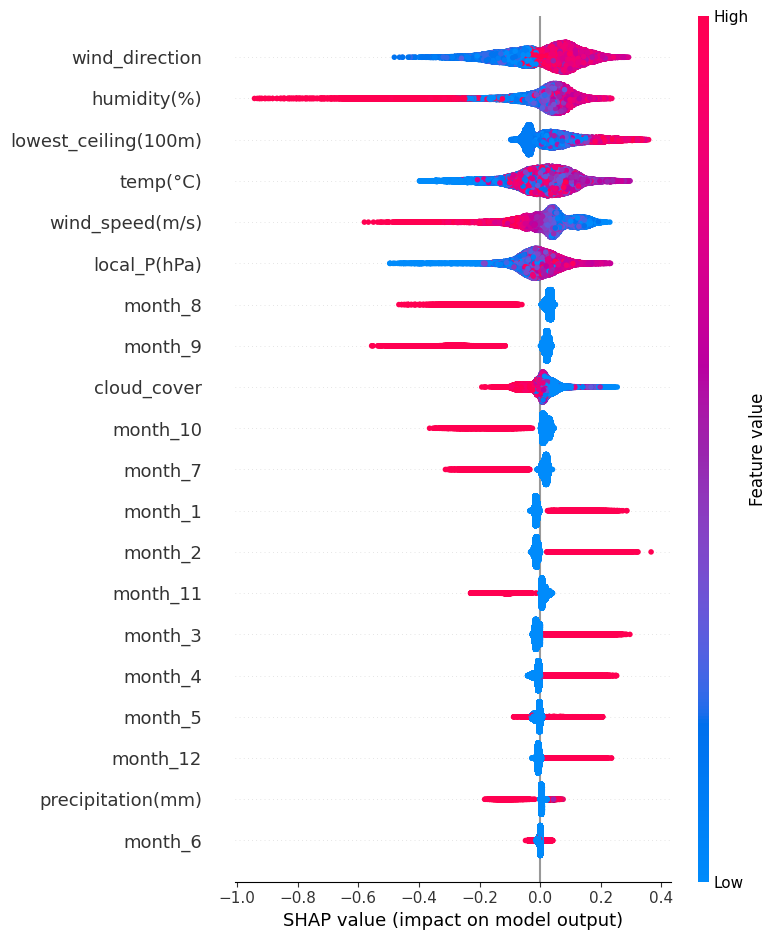

In [16]:
# To make the summary_plot work, I modified the code in
# C:\Users\johnw\AppData\Roaming\Python\Python310\site-packages\shap\_beeswarm.py (line 865)
fig = plt.gcf()
shap.summary_plot(shap_values)
fig.savefig('../img/feature_effect.png', bbox_inches='tight')

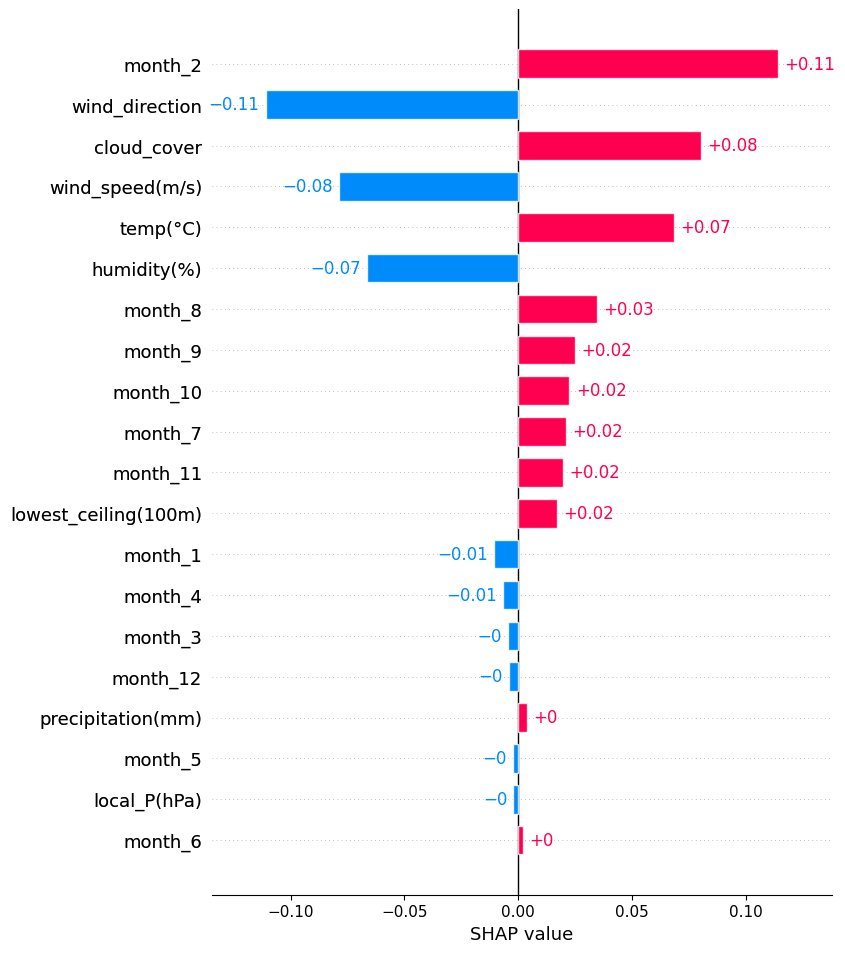

In [17]:
shap.plots.bar(shap_values[1000], max_display=20)

In [18]:
shap.plots.force(shap_values[1000])

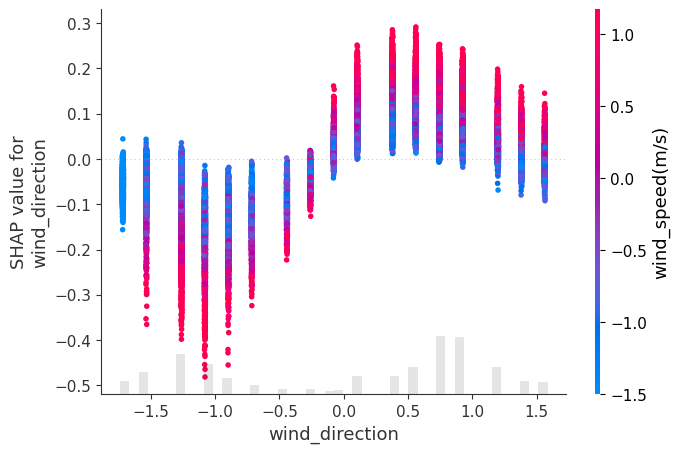

In [19]:
shap.plots.scatter(shap_values[:, "wind_direction"], color=shap_values, show=False)  # Need show=False to save the figure
plt.savefig('../img/wind_direction_effect.png', bbox_inches='tight')

The value for `wind_direction` ranges from 0 to 360. Since the values were scaled, -1.9/1.7, -1.0, 0, and 0.8 correspond to North, East, South, and West. This graph tells us that the particle count would be lowest when the wind blows from East, and it would be highest when the wind blows from West, which matches well with the actual situation in Korea.

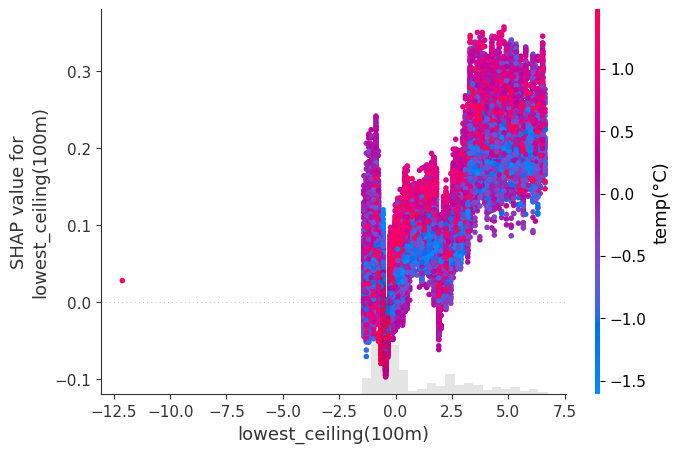

In [20]:
shap.plots.scatter(shap_values[:, "lowest_ceiling(100m)"], color=shap_values)

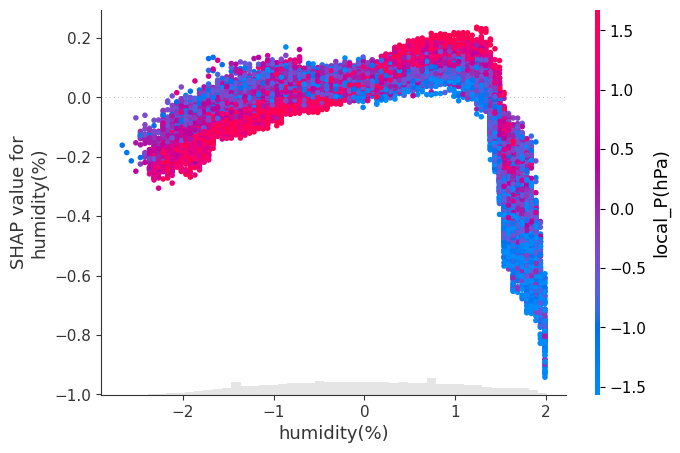

In [21]:
shap.plots.scatter(shap_values[:, "humidity(%)"], color=shap_values, show=False)
plt.savefig('../img/humidity_effect.png', bbox_inches='tight')

The above graph shows the particle counts get small when the `humidity(%)` is really high. This may has something to do with rain, because rain removes the find dust particles in the air. The graph shown below backs up this explanation.

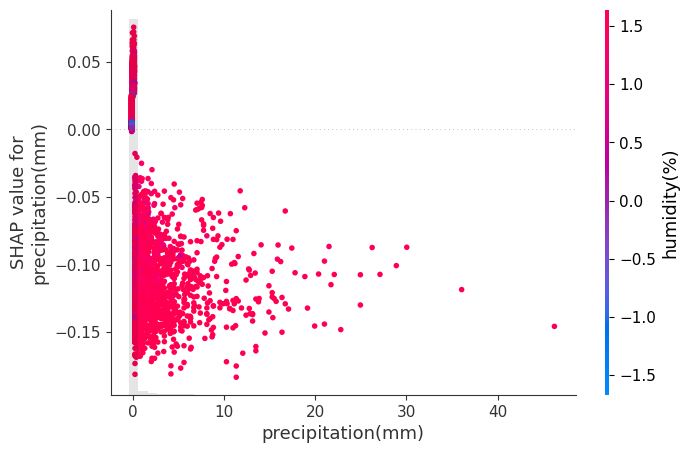

In [22]:
shap.plots.scatter(shap_values[:, "precipitation(mm)"], color=shap_values, show=False)
plt.savefig('../img/precipitation_effect.png', bbox_inches='tight')

If there are any amount of precipitation, the partcle counts tend to be low.

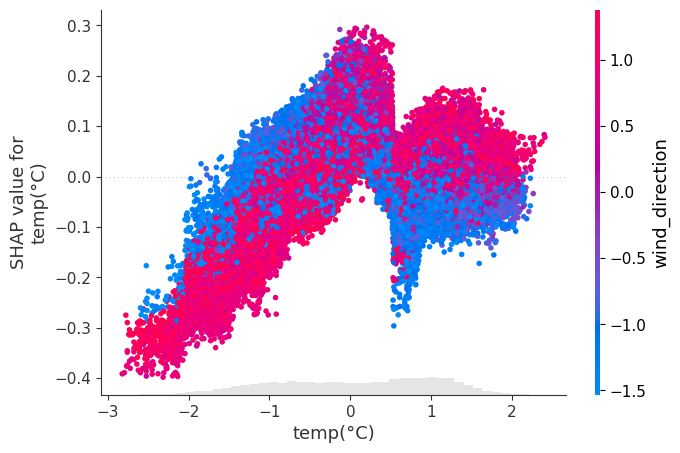

In [23]:
shap.plots.scatter(shap_values[:, "temp(°C)"], color=shap_values)